In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns
import geopandas
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import datetime as dt
import plotly.express as px

pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [2]:
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
print(accepted.shape)

D:\software\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260701, 151)


In [3]:
accepted.head(5)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years       MORTGAGE     55000.0        Not Verified  Dec-2015   
1  10+ years       MORTGAGE     65000.0        Not Verified  Dec-2015   
2  10+ years       MORTGAGE     63000.0        Not Verified  Dec-2015   
3  10+ years       MORTGAGE    110000.0     Source Verified  Dec-2015   
4    3 years       MORTGAGE    104433.0     Source Verified  Dec-2015   

  loan_status pymnt_plan                                                url  \
0  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
1  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
2  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
3     Current          n  https://lendingclub.com/browse/loanDetail.acti...   
4  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   

  desc             purpose               title zip_code addr_state    dti  \
0  NaN  debt_consolidation  Debt consolidation    190xx         PA   5.91   
1  NaN      small_business            Business    577xx         SD  16.06   
2  NaN    home_improvement                 NaN    605xx         IL  10.78   
3  NaN  debt_consolidation  Debt consolidation    076xx         NJ  17.06   
4  NaN      major_purchase      Major purchase    174xx         PA  25.37   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Aug-2003           675.0            679.0   
1          1.0         Dec-1999           715.0            719.0   
2          0.0         Aug-2000           695.0            699.0   
3          0.0         Sep-2008           785.0            789.0   
4          1.0         Jun-1998           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                    30.0                     NaN       7.0   
1             4.0                     6.0                     NaN      22.0   
2             0.0                     NaN                     NaN       6.0   
3             0.0                     NaN                     NaN      13.0   
4             3.0                    12.0                     NaN      12.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0      0.0     2765.0        29.7       13.0                   w       0.00   
1      0.0    21470.0        19.2       38.0                   w       0.00   
2      0.0     7869.0        56.2       18.0                   w       0.00   
3      0.0     7802.0        11.6       17.0                   w   15897.65   
4      0.0    21929.0        64.5       35.0                   w       0.00   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00   4421.723917          4421.72          3600.00   
1           0.00  25679.660000         25679.66         24700.00   
2           0.00  22705.924294         22705.92         20000.00   
3       15897.65  31464.010000         31464.01         19102.35   
4           0.00  1

In [80]:
accepted.loc[accepted['loan_status']=='Fully Paid','loan_status'] = 0
accepted.loc[accepted['loan_status']=='Does not meet the credit policy. Status:Fully Paid','loan_status'] = 0
accepted.loc[accepted['loan_status']=='Does not meet the credit policy. Status:Charged Off','loan_status'] = 1
accepted.loc[accepted['loan_status']=='Charged Off','loan_status'] = 1
accepted.loc[accepted['loan_status']=='Default','loan_status'] = 1

accepted.loc[(accepted['loan_status']==1) | (accepted['loan_status']==0)].groupby(['grade'])['loan_status'].value_counts()

grade  loan_status
A      0              220979
       1               14214
B      0              340441
       1               52661
C      0              296518
       1               85805
D      0              140393
       1               61264
E      0               57993
       1               36199
F      0               17721
       1               14585
G      0                4694
       1                4632
Name: loan_status, dtype: int64

In [93]:
4632/(4632+4694)

0.49667595968260775

In [4]:
accepted.isnull().sum()

id                                                  0
member_id                                     2260701
loan_amnt                                          33
funded_amnt                                        33
funded_amnt_inv                                    33
term                                               33
int_rate                                           33
installment                                        33
grade                                              33
sub_grade                                          33
emp_title                                      167002
emp_length                                     146940
home_ownership                                     33
annual_inc                                         37
verification_status                                33
issue_d                                            33
loan_status                                        33
pymnt_plan                                         33
url                         

In [5]:
accepted['date'] = pd.to_datetime(accepted['issue_d'], format='%b-%Y')
accepted['year'] = accepted['date'].dt.year
accepted['month'] = accepted['date'].dt.month
accepted['profit'] = (accepted['total_pymnt']-accepted['loan_amnt'])/accepted['loan_amnt']

In [ ]:
accepted.loc[(accepted['grade']=='B') & (accepted['int_rate']!=6)]['int_rate'].min()

In [ ]:
accepted.groupby('grade')['int_rate'].agg(['min','max','mean','std'])

In [48]:
model_df=accepted[['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_title','emp_length','home_ownership',\
                   'annual_inc','date','loan_status','purpose','addr_state','dti','delinq_2yrs','earliest_cr_line','fico_range_low',\
                   'fico_range_high','inq_last_6mths','mths_since_last_delinq','mths_since_last_record','open_acc','pub_rec',\
                   'revol_bal','revol_util','total_acc', 'acc_now_delinq','delinq_amnt', 'mths_since_last_major_derog',\
                   'collections_12_mths_ex_med','application_type','year','month','profit']]

# drop missing valus rows by 'grade'
model_df = model_df.dropna(how='any', subset=['grade'])

# select loan grade of E, F, and G
model_df = model_df[model_df['grade'].isin(['E','F','G'])]

# convert loan status to binary (fully paid and defaulted)
model_df.loc[model_df['loan_status']=='Fully Paid','loan_status'] = 0
model_df.loc[model_df['loan_status']=='Does not meet the credit policy. Status:Fully Paid','loan_status'] = 0
model_df.loc[model_df['loan_status']=='Does not meet the credit policy. Status:Charged Off','loan_status'] = 1
model_df.loc[model_df['loan_status']=='Charged Off','loan_status'] = 1
model_df.loc[model_df['loan_status']=='Default','loan_status'] = 1

# convert address state into 8 regions
new_england = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']
mideast = ['DE', 'DC', 'MD', 'NJ', 'NY', 'PA']
great_lakes = ['IL', 'IN', 'MI', 'OH', 'WI']
plains = ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
south_east = ['AL', 'AR', 'FL', 'GA', 'KY','LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV']
south_west = ['AZ','NM','OK','TX']
rocky_mountain = ['CO','ID','MT','UT','WY']
west = ['AK','CA','HI','NV','OR','WA']
def regions(state):
    if state in new_england:
        return 'NewEngland'
    elif state in mideast:
        return 'MidEast'
    elif state in great_lakes:
        return 'GreatLakes'
    elif state in plains:
        return 'Plains'
    elif state in south_east:
        return 'SouthEast'
    elif state in south_west:
        return 'SouthWest'
    elif state in rocky_mountain:
        return 'RockyMountain'
    elif state in west:
        return 'West'    
model_df['region'] = model_df['addr_state'].apply(regions)

# select observations that interested
model_df = model_df.loc[(model_df['loan_status']==1) | (model_df['loan_status']==0)]


In [49]:
model_df['loan_status'].value_counts()

0    80408
1    55416
Name: loan_status, dtype: int64

In [ ]:
model_df.info()

[Text(0.5, 1.0, 'Loan amount distribution')]

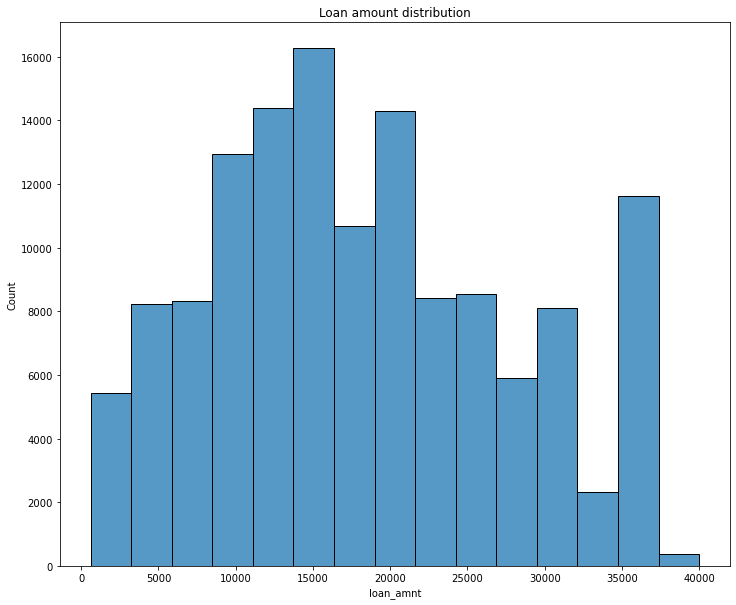

In [7]:
plt.figure(figsize=(12,10))
sns.histplot(model_df,x='loan_amnt',bins=15,).set(title='Loan amount distribution')

[Text(0.5, 1.0, 'Total Loan Amount by Grade')]

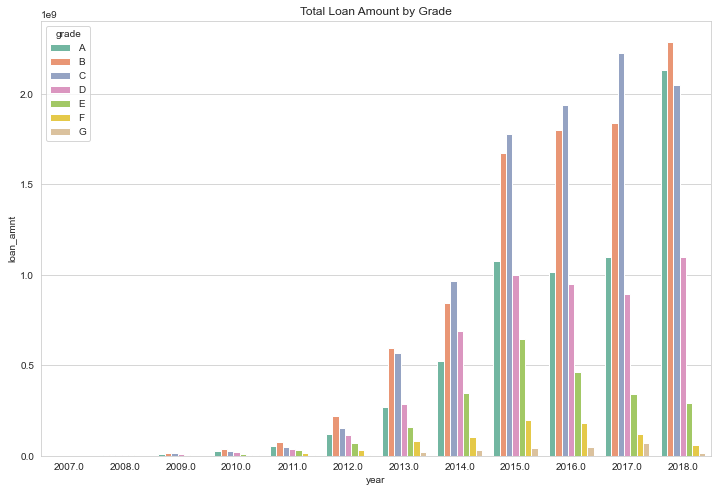

In [51]:
temp_all = pd.DataFrame(accepted.groupby(['year','grade'])['loan_amnt'].sum().reset_index())
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.barplot(data=temp_all,x='year',y='loan_amnt', hue='grade',hue_order=['A','B','C','D','E','F','G'],palette='Set2').set(title='Total Loan Amount by Grade')

[Text(0.5, 1.0, 'Total Loan Amount by Grade')]

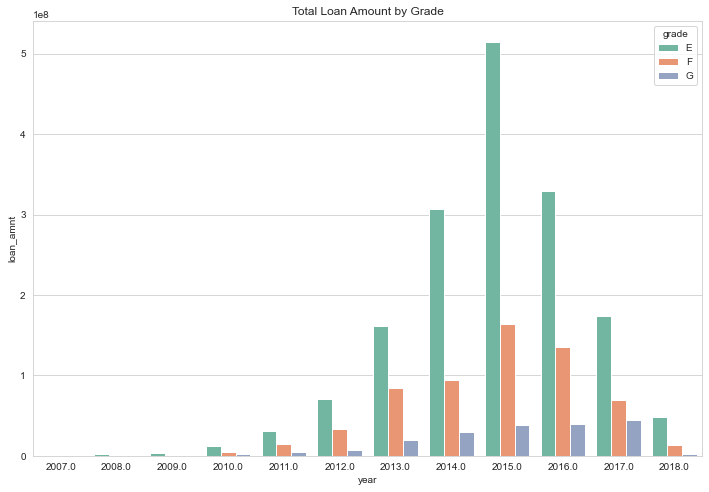

In [8]:
temp = pd.DataFrame(model_df.groupby(['year','grade'])['loan_amnt'].sum().reset_index())
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.barplot(data=temp,x='year',y='loan_amnt', hue='grade',hue_order=['E','F','G'],palette='Set2').set(title='Total Loan Amount by Grade')

[Text(0.5, 1.0, 'Loan Amount by Grade')]

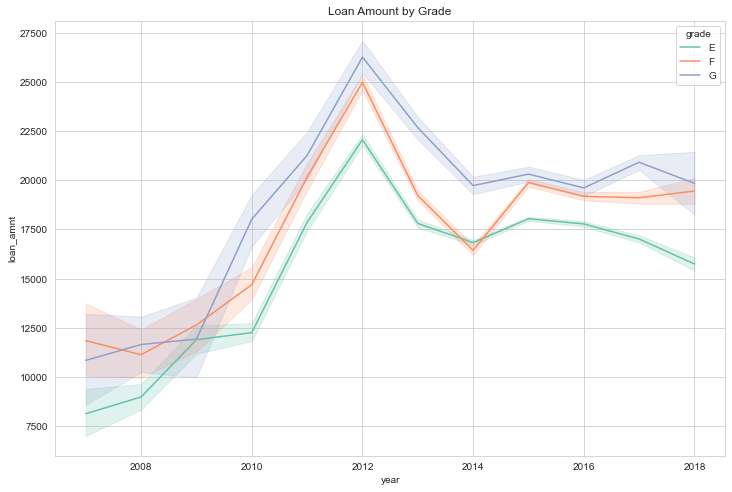

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=model_df,x='year',y='loan_amnt', hue='grade',hue_order=['E','F','G'],palette='Set2').set(title='Loan Amount by Grade')

[Text(0.5, 1.0, 'Profit by Loan Grade (median)')]

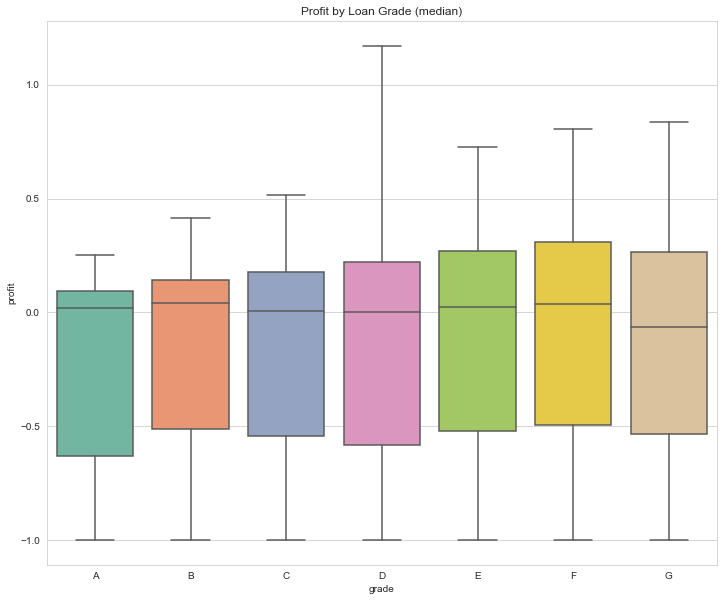

In [68]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,10))
sns.boxplot(x='grade',order=['A','B','C','D','E','F','G'],y='profit',data=accepted,palette='Set2').set(title='Profit by Loan Grade (median)')

[Text(0.5, 1.0, 'Profit by Loan Grade (mean)')]

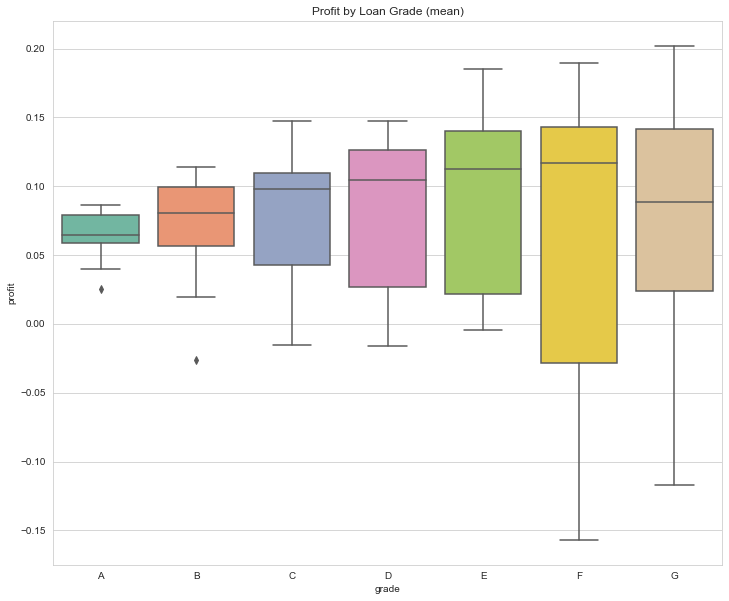

In [66]:
temp_profit_all = accepted.groupby(['year','grade'])['profit'].mean().reset_index()
temp_profit_all = temp_profit_all.loc[temp_profit_all['year']<2016]
sns.set_style('whitegrid')
plt.figure(figsize=(12,10))
sns.boxplot(x='grade',y='profit',data=temp_profit_all,palette='Set2').set(title='Profit by Loan Grade (mean)')

[Text(0.5, 1.0, 'Profit by Loan Grade (mean)')]

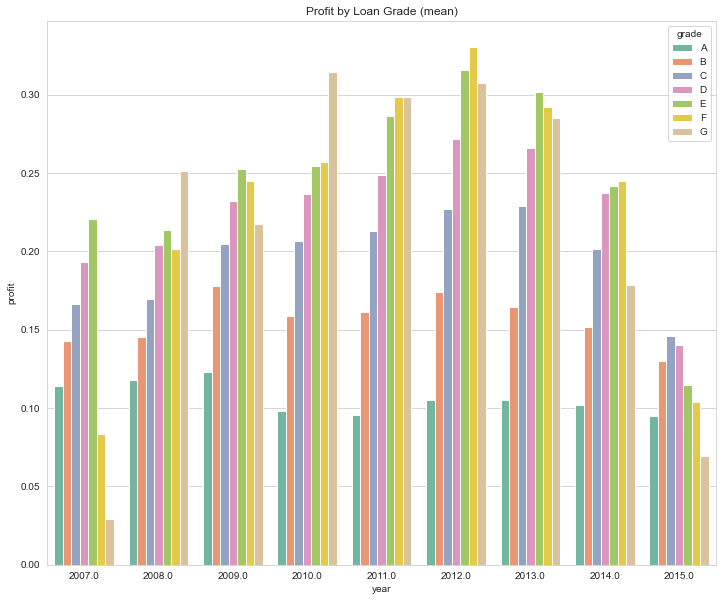

In [55]:
temp_profit_all = accepted.groupby(['year','grade'])['profit'].median().reset_index()
temp_profit_all = temp_profit_all.loc[temp_profit_all['year']<2016]
sns.set_style('whitegrid')
plt.figure(figsize=(12,10))
sns.barplot(x='year',y='profit',data=temp_profit_all,hue='grade',hue_order=['A','B','C','D','E','F','G'],palette='Set2').set(title='Profit by Loan Grade (mean)')

[Text(0.5, 1.0, 'Profit by Loan Grade (mean)')]

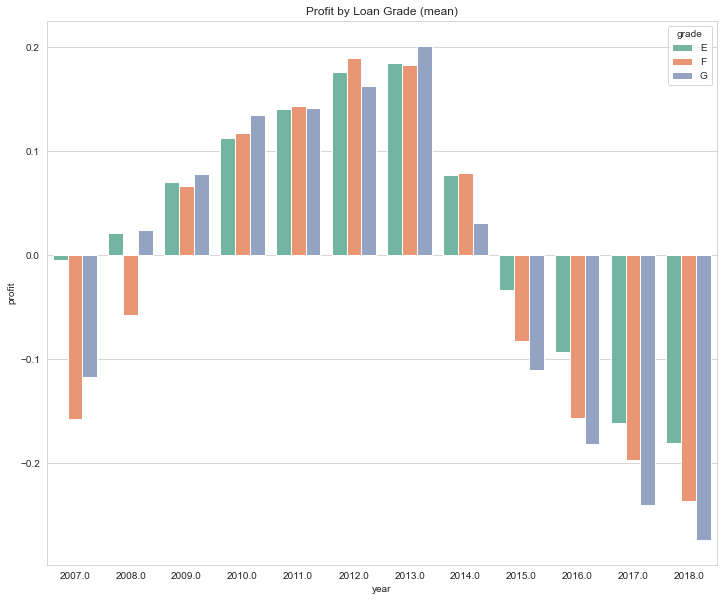

In [11]:
temp_profit = model_df.groupby(['year','grade'])['profit'].mean().reset_index()
sns.set_style('whitegrid')
plt.figure(figsize=(12,10))
sns.barplot(x='year',y='profit',data=temp_profit,hue='grade',hue_order=['E','F','G'],palette='Set2').set(title='Profit by Loan Grade (mean)')

In [12]:
model_df['emp_length'].unique()

array(['3 years', '7 years', '8 years', '4 years', '10+ years', '2 years',
       '6 years', '< 1 year', '1 year', '9 years', nan, '5 years'],
      dtype=object)

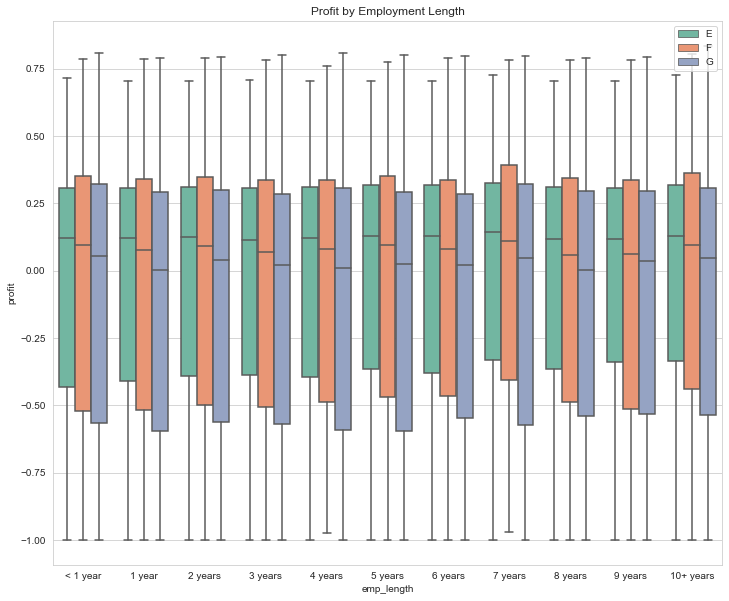

In [13]:
plt.figure(figsize=(12,10))
sns.boxplot(x='emp_length',order=['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years', '8 years','9 years','10+ years'],y='profit',data=model_df,hue='grade',hue_order=['E','F','G'],palette='Set2').set(title='Profit by Employment Length')
plt.legend(loc='upper right')

[Text(0.5, 1.0, 'Profit by Loan Term')]

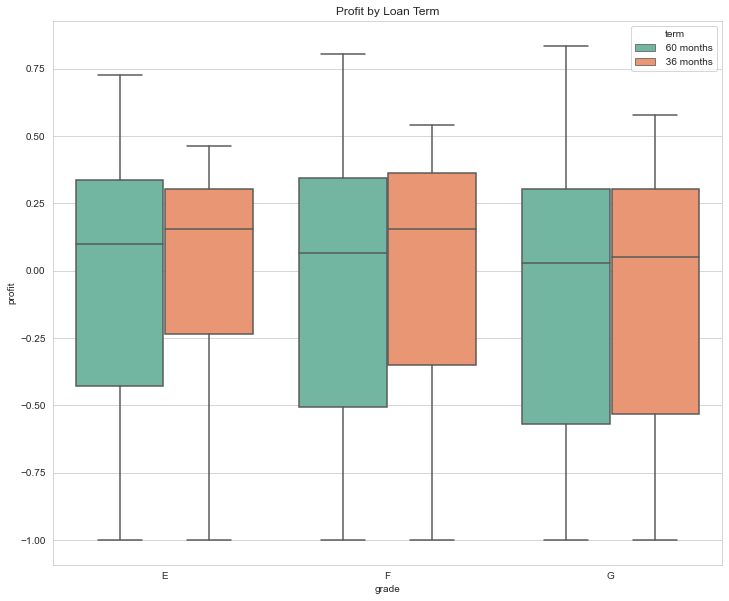

In [14]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sns.boxplot(x='grade',y='profit',data = model_df,hue='term',order=['E','F','G'],palette='Set2').set(title='Profit by Loan Term')


[Text(0.5, 1.0, 'Annual Income')]

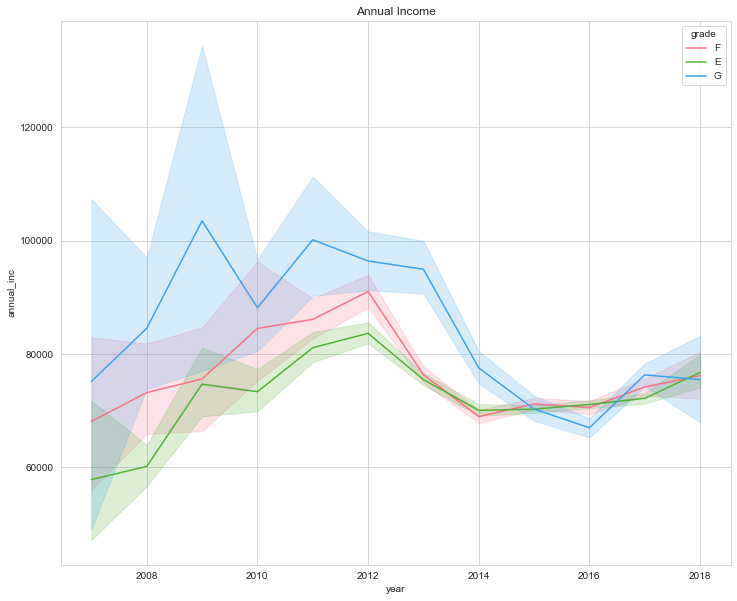

In [15]:
# by_inc = pd.DataFrame(model_df.groupby(['year','grade'])['annual_inc'].mean().reset_index())
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='annual_inc',hue='grade',palette='husl').set(title='Annual Income')

[Text(0.5, 1.0, 'interest rate')]

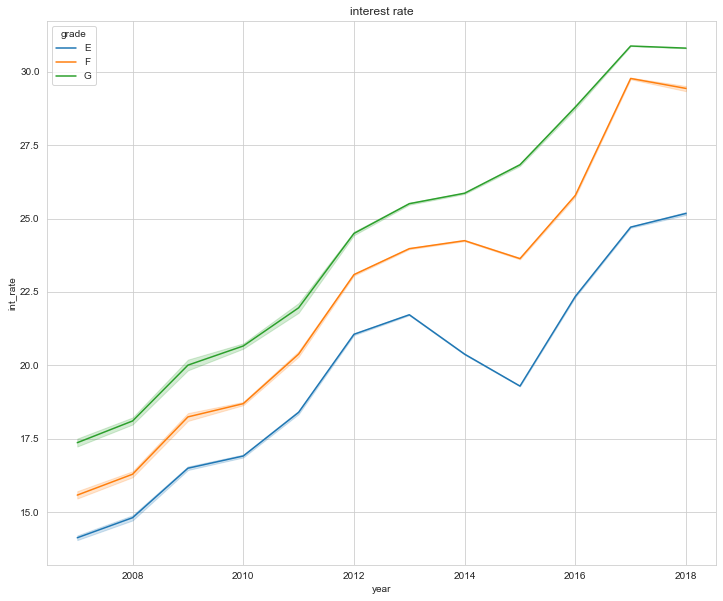

In [16]:
# by_int_rate = pd.DataFrame(model_df.groupby(['year','grade'])['int_rate'].mean().reset_index())
# by_int_rate.head()
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='int_rate',hue='grade',hue_order=['E','F','G']).set(title='interest rate')

[Text(0.5, 1.0, 'Annual Income by Region')]

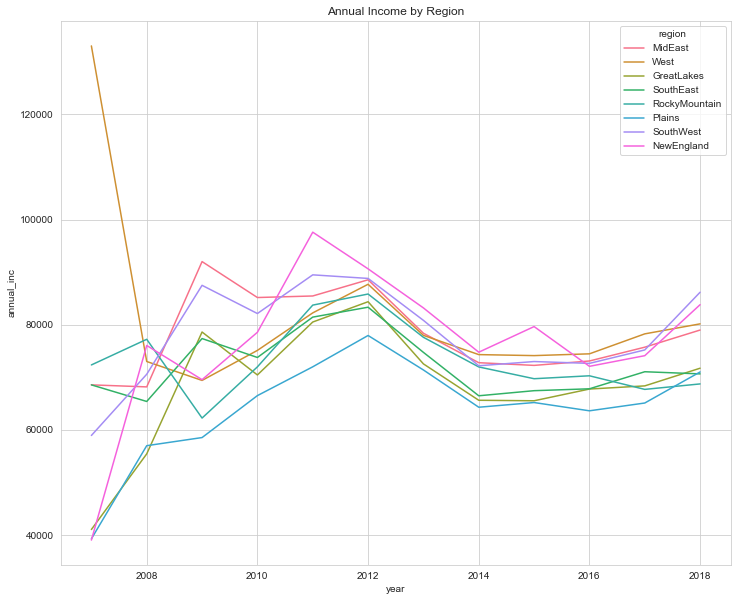

In [17]:
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='annual_inc',hue='region',palette='husl',err_style=None).set(title='Annual Income by Region')

[Text(0.5, 1.0, 'Profit by Region')]

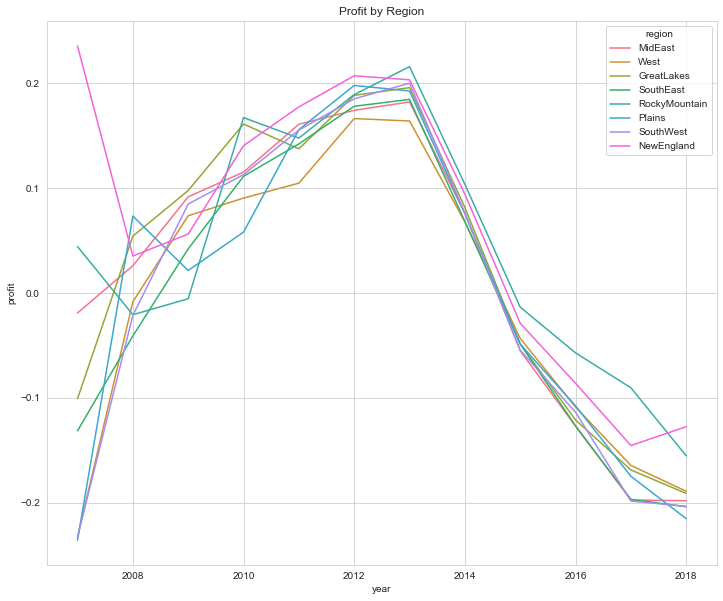

In [18]:
plt.figure(figsize=(12,10))
sns.lineplot(data=model_df, x='year',y='profit',hue='region',palette='husl',err_style=None).set(title='Profit by Region')

[Text(0.5, 1.0, 'Good Loan vs. Bad Loan by Region')]

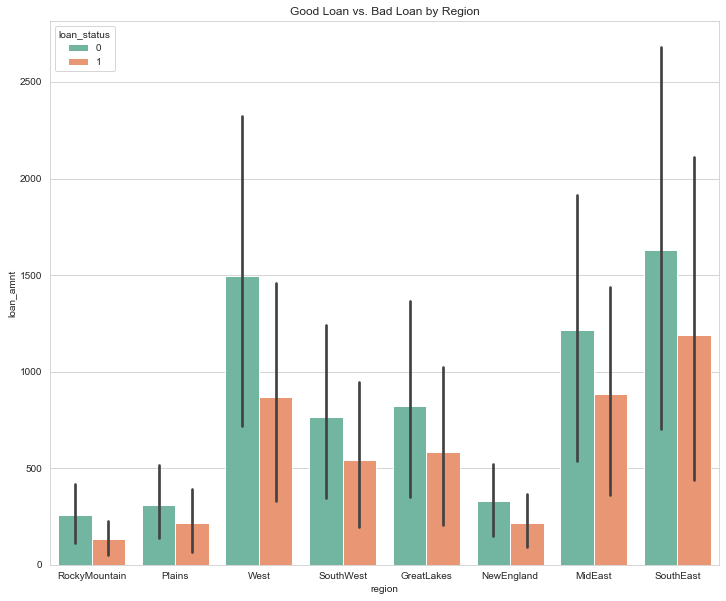

In [19]:
temp_region = pd.DataFrame(model_df.groupby(['year','region','loan_status'])['loan_amnt'].count().sort_values().reset_index())
plt.figure(figsize=(12,10))
sns.barplot(data=temp_region, x='region',y='loan_amnt',hue='loan_status',palette='Set2').set(title='Good Loan vs. Bad Loan by Region')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'educational'),
  Text(1, 0, 'renewable_energy'),
  Text(2, 0, 'wedding'),
  Text(3, 0, 'vacation'),
  Text(4, 0, 'car'),
  Text(5, 0, 'moving'),
  Text(6, 0, 'house'),
  Text(7, 0, 'medical'),
  Text(8, 0, 'major_purchase'),
  Text(9, 0, 'small_business'),
  Text(10, 0, 'home_improvement'),
  Text(11, 0, 'other'),
  Text(12, 0, 'credit_card'),
  Text(13, 0, 'debt_consolidation')])

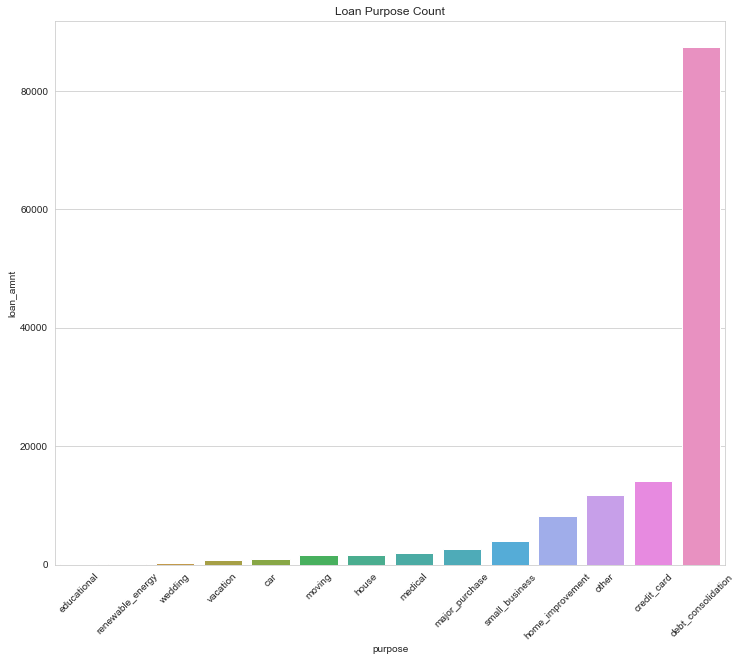

In [20]:
plt.figure(figsize=(12,10))
temp_purpose = pd.DataFrame(model_df.groupby(['purpose'])['loan_amnt'].count().sort_values().reset_index())
sns.barplot(x='purpose',y='loan_amnt',data=temp_purpose).set(title='Loan Purpose Count')
plt.xticks(rotation=45)

In [ ]:
# Loan Count by Purpose for all loan grade
plt.figure(figsize=(12,6))
temp_purpose_all = pd.DataFrame(accepted.groupby(['purpose'])['loan_amnt'].count().sort_values().reset_index())
# list(reversed(temp_grade_all["loan_amnt"]))
sns.barplot(y='purpose',x='loan_amnt',order=list(reversed(temp_purpose_all["purpose"])),data=temp_purpose_all,orient='h',palette='Set2').set(title='Loan Purpose Count',xlabel='Count')

plt.yticks(fontsize=15)
# plt.xticks(rotation=45)

In [ ]:
# All loan grade count 
plt.figure(figsize=(12,6))
temp_grade_all = pd.DataFrame(accepted.groupby(['grade'])['loan_amnt'].count().sort_values().reset_index())
# list(reversed(temp_grade_all["loan_amnt"]))
sns.barplot(y='grade',x='loan_amnt',order=['A','B','C','D','E','F','G'],data=temp_grade_all,orient='h',palette='Set2').set(title='Loan Grade Count',xlabel='Count')

plt.yticks(fontsize=15)
# plt.xticks(rotation=45)

(array([0, 1, 2]), [Text(0, 0, 'E'), Text(0, 1, 'F'), Text(0, 2, 'G')])

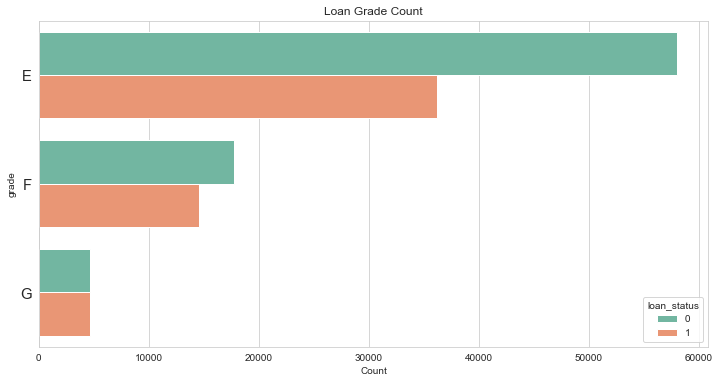

In [24]:
plt.figure(figsize=(12,6))
temp_grade_all = pd.DataFrame(model_df.groupby(['grade','loan_status'])['loan_amnt'].count().sort_values().reset_index())
# list(reversed(temp_grade_all["loan_amnt"]))
sns.barplot(y='grade',x='loan_amnt',data=temp_grade_all,hue='loan_status',order=['E','F','G'],orient='h',palette='Set2').set(title='Loan Grade Count',xlabel='Count')

plt.yticks(fontsize=15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'house'),
  Text(1, 0, 'medical'),
  Text(2, 0, 'other'),
  Text(3, 0, 'small_business'),
  Text(4, 0, 'major_purchase'),
  Text(5, 0, 'vacation'),
  Text(6, 0, 'moving'),
  Text(7, 0, 'home_improvement'),
  Text(8, 0, 'credit_card'),
  Text(9, 0, 'renewable_energy'),
  Text(10, 0, 'car'),
  Text(11, 0, 'debt_consolidation'),
  Text(12, 0, 'educational'),
  Text(13, 0, 'wedding')])

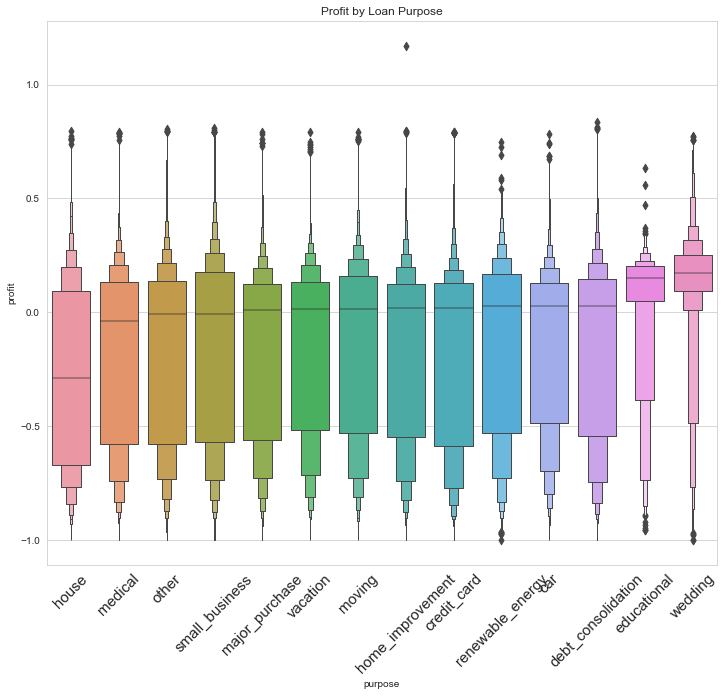

In [25]:
# profit by loan purpose for all grade
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sorted_index = accepted.groupby('purpose')['profit'].median().sort_values().index
sns.boxenplot(x='purpose',y='profit',order=sorted_index,data=accepted).set(title='Profit by Loan Purpose')
plt.xticks(rotation=45,fontsize = 15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'major_purchase'),
  Text(1, 0, 'debt_consolidation'),
  Text(2, 0, 'house'),
  Text(3, 0, 'credit_card'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'renewable_energy'),
  Text(6, 0, 'small_business'),
  Text(7, 0, 'car'),
  Text(8, 0, 'medical'),
  Text(9, 0, 'moving'),
  Text(10, 0, 'other'),
  Text(11, 0, 'vacation'),
  Text(12, 0, 'educational'),
  Text(13, 0, 'wedding')])

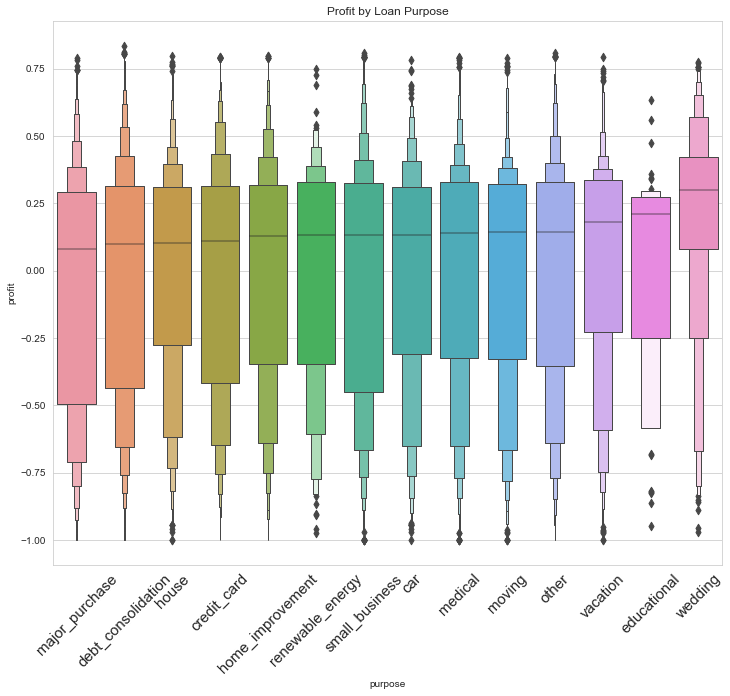

In [26]:
# profit by loan purpose for loan grade E, F, and G
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sorted_index = model_df.groupby('purpose')['profit'].median().sort_values().index
sns.boxenplot(x='purpose',y='profit',order=sorted_index,data=model_df).set(title='Profit by Loan Purpose')
plt.xticks(rotation=45,fontsize = 15)

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

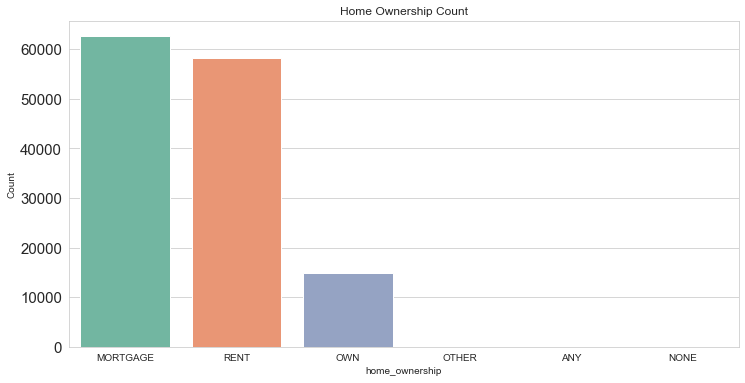

In [29]:
plt.figure(figsize=(12,6))
temp_home_all = pd.DataFrame(model_df.groupby(['home_ownership'])['loan_amnt'].count().sort_values().reset_index())
# list(reversed(temp_grade_all["loan_amnt"]))
sns.barplot(x='home_ownership',y='loan_amnt',order=list(reversed(temp_home_all["home_ownership"])),data=temp_home_all,palette='Set2').set(title='Home Ownership Count',ylabel='Count')

plt.yticks(fontsize=15)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'MORTGAGE'),
  Text(1, 0, 'RENT'),
  Text(2, 0, 'OWN'),
  Text(3, 0, 'ANY'),
  Text(4, 0, 'OTHER'),
  Text(5, 0, 'NONE')])

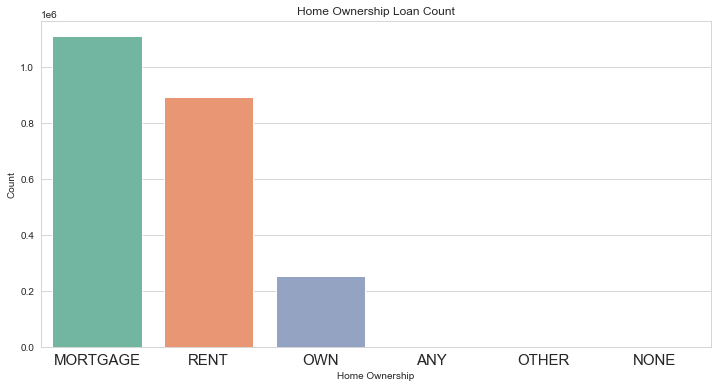

In [73]:
# Homeownership for all grade
plt.figure(figsize=(12,6))
temp_home_all = pd.DataFrame(accepted.groupby(['home_ownership'])['loan_amnt'].count().sort_values().reset_index())
# list(reversed(temp_grade_all["loan_amnt"]))
sns.barplot(x='home_ownership',y='loan_amnt',order=list(reversed(temp_home_all["home_ownership"])),data=temp_home_all,palette='Set2').set(title='Home Ownership Loan Count',xlabel='Home Ownership',ylabel='Count')

# plt.yticks(fontsize=15)
# plt.xticks(rotation=45)
plt.xticks(fontsize=15)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'OTHER'),
  Text(1, 0, 'RENT'),
  Text(2, 0, 'OWN'),
  Text(3, 0, 'MORTGAGE'),
  Text(4, 0, 'NONE')])

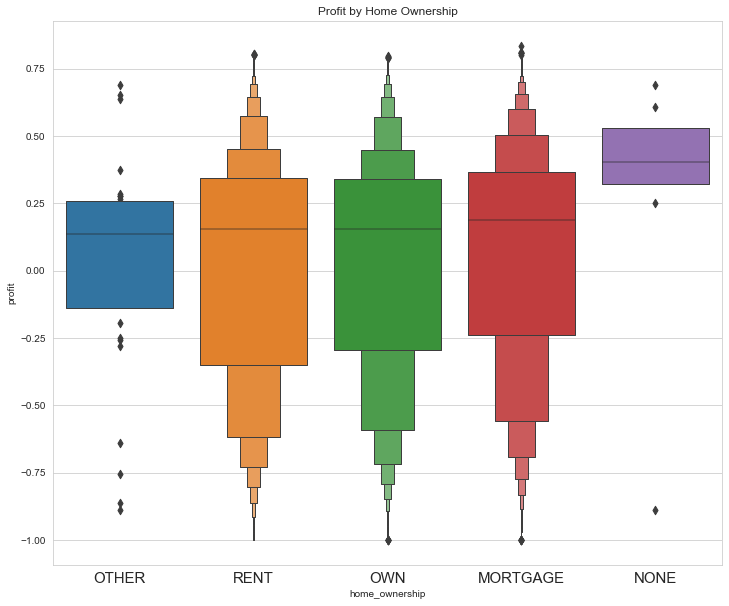

In [74]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')
sorted_index = model_df.loc[model_df['year']<2016].groupby(['home_ownership'])['profit'].median().sort_values().index
sns.boxenplot(x='home_ownership',y='profit',order=sorted_index,data=model_df.loc[model_df['year']<2016]).set(title='Profit by Home Ownership')
plt.xticks(fontsize=15)

In [32]:
model_df.corr()

loan_amnt  int_rate  installment  annual_inc  \
loan_amnt                     1.000000  0.080663     0.948015    0.394320   
int_rate                      0.080663  1.000000     0.177835    0.015406   
installment                   0.948015  0.177835     1.000000    0.379373   
annual_inc                    0.394320  0.015406     0.379373    1.000000   
dti                           0.004706  0.055476     0.012880   -0.157478   
delinq_2yrs                   0.017082  0.000975     0.019874    0.062957   
fico_range_low                0.139101  0.016717     0.114241    0.040069   
fico_range_high               0.139102  0.016717     0.114241    0.040069   
inq_last_6mths               -0.046554 -0.000583    -0.022342    0.087647   
mths_since_last_delinq       -0.019080  0.007243    -0.020367   -0.050227   
mths_since_last_record        0.032958  0.096887     0.014062   -0.037515   
open_acc                      0.209735  0.029434     0.200091    0.160972   
pub_rec                      -0.043154  0.016880    -0.032276    0.013105   
revol_bal                     0.309824 -0.006171     0.291781    0.316158   
revol_util                    0.102625 -0.070257     0.082477    0.053409   
total_acc                     0.269653 -0.015883     0.237851    0.215456   
acc_now_delinq                0.005426 -0.007677     0.005104    0.019783   
delinq_amnt                  -0.000954  0.001079     0.000703    0.009771   
mths_since_last_major_derog   0.003820  0.009831     0.002146   -0.040398   
collections_12_mths_ex_med   -0.017229  0.009703    -0.014465   -0.004058   
year                          0.006557  0.479342     0.081586   -0.030367   
month                         0.011540  0.011664     0.003811    0.008527   
profit                       -0.027873 -0.136756    -0.041726    0.040080   

                                  dti  delinq_2yrs  fico_range_low  \
loan_amnt                    0.004706     0.017082        0.139101   
int_rate                     0.055476     0.000975        0.016717   
installment                  0.012880     0.019874        0.114241   
annual_inc                  -0.157478     0.062957        0.040069   
dti                          1.000000    -0.031556        0.001829   
delinq_2yrs                 -0.031556     1.000000       -0.118435   
fico_range_low               0.001829    -0.118435        1.000000   
fico_range_high              0.001829    -0.118435        1.000000   
inq_last_6mths              -0.069108     0.023362       -0.033986   
mths_since_last_delinq       0.033836    -0.549882        0.045838   
mths_since_last_record       0.085830    -0.066524        0.188803   
open_acc                     0.199258     0.033025       -0.032816   
pub_rec                     -0.027971    -0.020613       -0.133204   
revol_bal                    0.109489    -0.041277        0.029984   
revol_util                   0.106233    -0.085730       -0.300832   
total_acc                    0.154042     0.128913       -0.046489   
acc_now_delinq              -0.005676     0.140864       -0.026055   
delinq_amnt                 -0.009845     0.033667       -0.010931   
mths_since_last_major_derog  0.051966    -0.434261        0.032662   
collections_12_mths_ex_med  -0.008803     0.072490       -0.043625   
year                         0.142943     0.001665        0.109885   
month                       -0.015722     0.006037        0.010994   
profit                      -0.065121     0.006572       -0.017557   

                             fico_range_high  inq_last_6mths  \
loan_amnt                           0.139102       -0.046554   
int_rate                            0.016717       -0.000583   
installment                         0.114241       -0.022342   
annual_inc                          0.040069        0.087647   
dti                                 0.001829       -0.069108   
delinq_2yrs                        -0.118435        0.023362   
fico_range_low                      1.000000       

<AxesSubplot:>

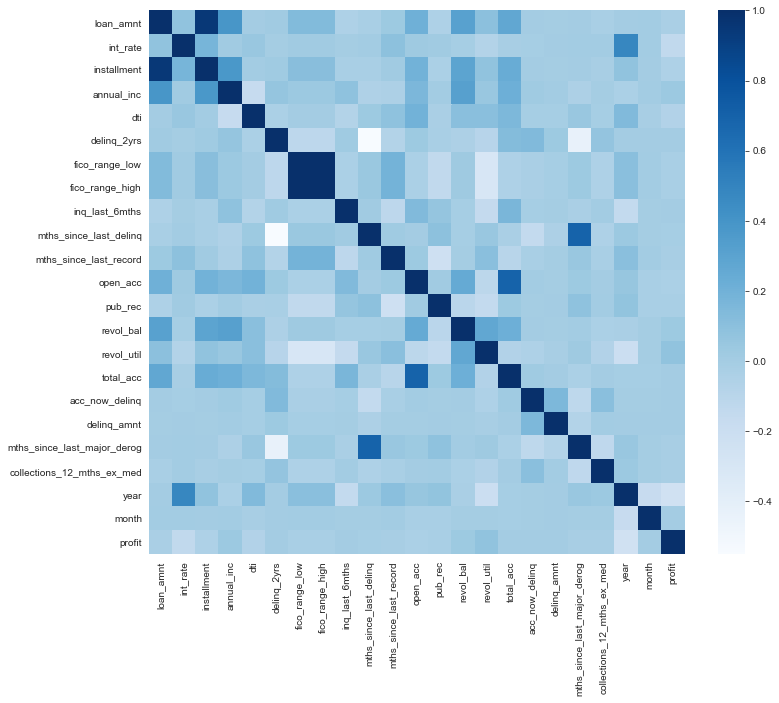

In [33]:
plt.figure(figsize=(12,10))
sns.heatmap(model_df.corr(),cmap='Blues')

- fico_range_low and fico_range_high are perfectly correlated, so fico_range_low feature will be dropped from the model_df
- installment is highly correlated with loan amount, so installment will be dropped from the model_df

In [34]:
# facet plot: loan status by loan grade across year 

temp_sum = pd.DataFrame(model_df.groupby(['year','grade','loan_status'])['loan_amnt'].count().reset_index())
temp_sum['loan_status'] = temp_sum['loan_status'].astype('object')
fig = px.bar(temp_sum,x='year',y='loan_amnt',facet_col='grade',color='loan_status',barmode='group')
fig.update_layout(yaxis_title="count",title="Loan Status")
fig.show()

In [ ]:
status_group = model_df.groupby(['grade','year','loan_status'])['loan_status'].count()
status_group.groupby('grade').apply(lambda x: x/float(x.sum()))

[Text(0.5, 1.0, 'fico score by loan status')]

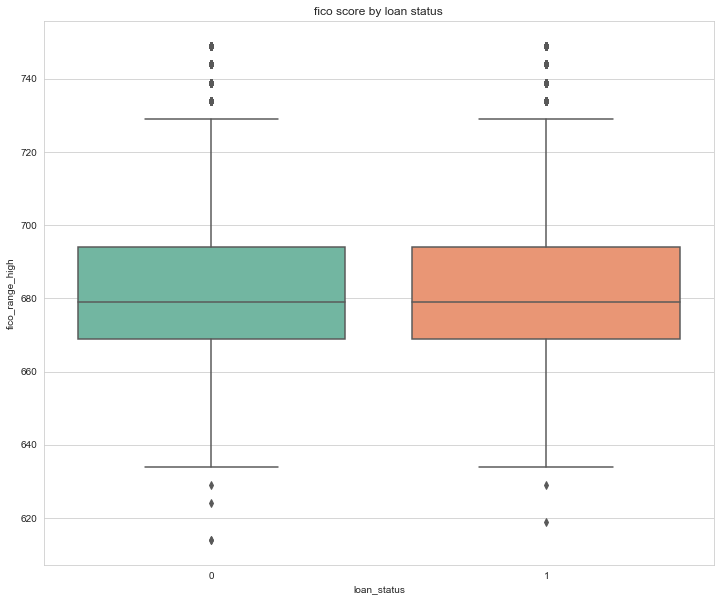

In [40]:
plt.figure(figsize=(12,10))
sns.boxplot(x='loan_status',y='fico_range_high',data=model_df.loc[model_df['fico_range_high']<750,:] ,palette='Set2').set(title='fico score by loan status')

[Text(0.5, 1.0, 'dti by loan status')]

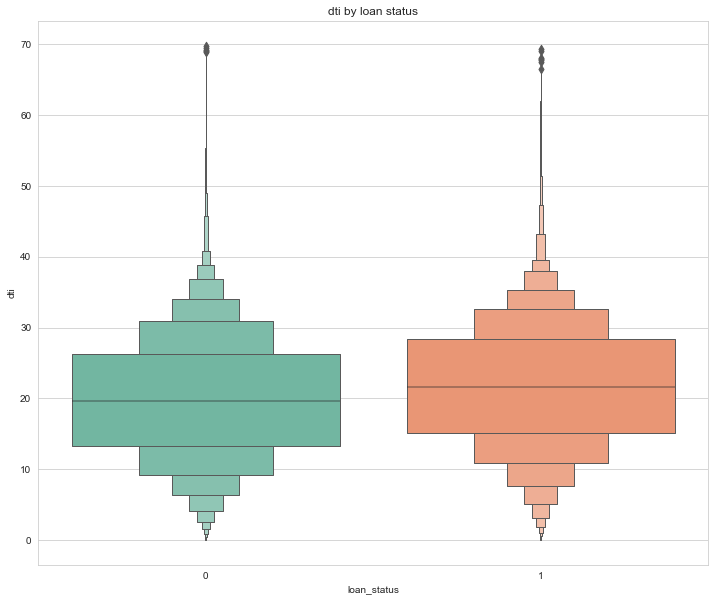

In [41]:
plt.figure(figsize=(12,10))
sns.boxenplot(x='loan_status',y='dti',data=model_df.loc[model_df['dti']<70,:], palette='Set2').set(title='dti by loan status')

[Text(0.5, 1.0, 'Revolving utilization rate by loan status ')]

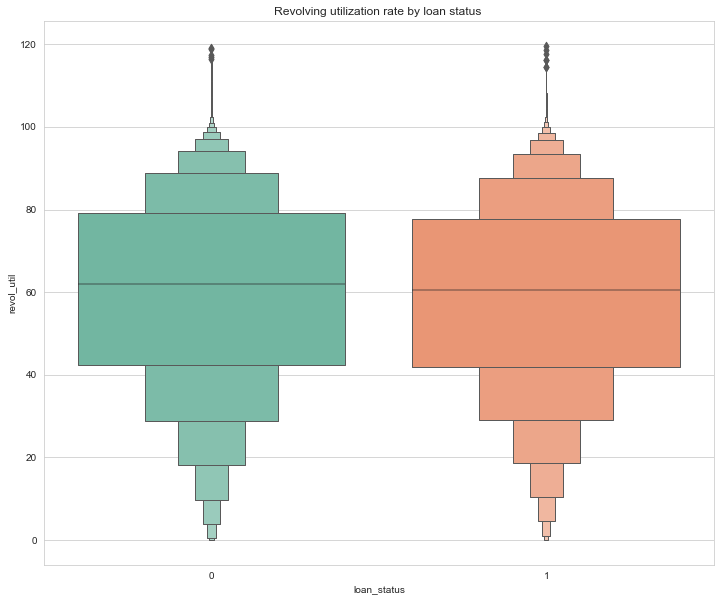

In [42]:
plt.figure(figsize=(12,10))
sns.boxenplot(x='loan_status',y='revol_util',data=model_df.loc[model_df['revol_util']<120,:], palette='Set2').set(title='Revolving utilization rate by loan status ')

[Text(0.5, 1.0, 'annual income')]

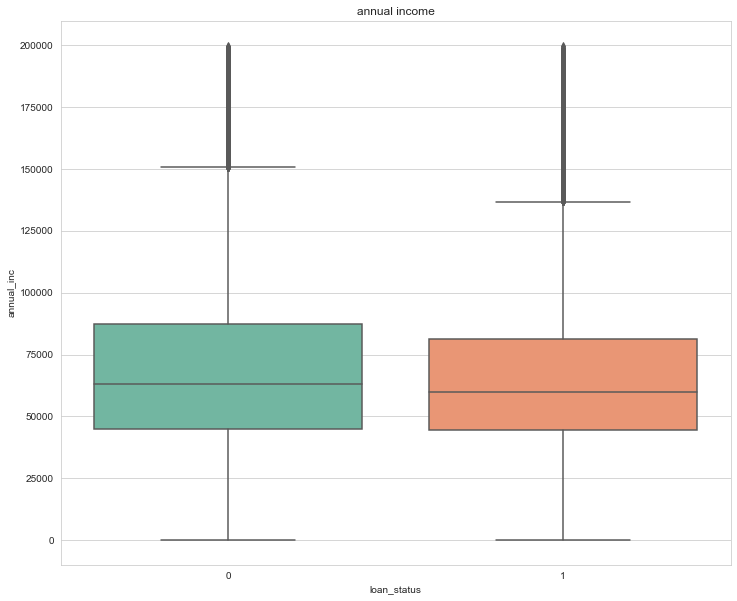

In [43]:
plt.figure(figsize=(12,10))
sns.boxplot(x='loan_status',y='annual_inc',data=model_df.loc[model_df['annual_inc']<2e5,:], palette='Set2').set(title='annual income')

In [44]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135824 entries, 4 to 2260519
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   loan_amnt                    135824 non-null  float64       
 1   term                         135824 non-null  object        
 2   int_rate                     135824 non-null  float64       
 3   installment                  135824 non-null  float64       
 4   grade                        135824 non-null  object        
 5   sub_grade                    135824 non-null  object        
 6   emp_title                    127571 non-null  object        
 7   emp_length                   128336 non-null  object        
 8   home_ownership               135824 non-null  object        
 9   annual_inc                   135824 non-null  float64       
 10  date                         135824 non-null  datetime64[ns]
 11  loan_status              

In [45]:
model_df.isnull().sum()

loan_amnt                           0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                        8253
emp_length                       7488
home_ownership                      0
annual_inc                          0
date                                0
loan_status                         0
purpose                             0
addr_state                          0
dti                                45
delinq_2yrs                         1
earliest_cr_line                    1
fico_range_low                      0
fico_range_high                     0
inq_last_6mths                      1
mths_since_last_delinq          63726
mths_since_last_record         109816
open_acc                            1
pub_rec                             1
revol_bal                           0
revol_util                        145
total_acc   

In [46]:
# fill emp_length NAs with 0
model_df['emp_length'] = model_df['emp_length'].fillna('0')
model_df['emp_title'] = model_df['emp_title'].fillna('Unemployed')

# drop columns with lots of missing value
model_df = model_df.drop(['mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog'],axis=1)

# drop columns due to hig correlated and irrelevent 
model_df = model_df.drop(['month','fico_range_low','date','grade','emp_title','installment'],axis=1)

# drop rows with missing values
model_df = model_df.dropna(how='any',subset=['dti'])
model_df = model_df.dropna(how='any',subset=['revol_util'])
model_df = model_df.dropna(how='any',subset=['collections_12_mths_ex_med'])

In [ ]:
model_df.shape

In [ ]:
model_df.isnull().sum()

In [47]:
model_df.to_csv('model_df.csv')